In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import h5py

In [2]:
# Referred to Midterm template, Sree's practice notebook and GPT
class BRATS2020Dataset(Dataset):
    """
    Dataset class for BRATS2020 .h5 files. 
    Assumes each .h5 file contains 'image' and 'mask' keys.
    """

    def __init__(self, root_dir, n_sample=None, image_size=(256, 256), mask_size=(256, 256)):
        """
        Args:
            root_dir (str): Root directory with .h5 files.
            n_sample (int, optional): Number of samples to use. Defaults to all.
            image_size (tuple): Target image size.
            mask_size (tuple): Target mask size.
        """
        self.root_dir = root_dir
        self.file_paths = sorted(glob.glob(os.path.join(root_dir, '*.h5')))

        if n_sample and n_sample < len(self.file_paths):
            self.file_paths = self.file_paths[:n_sample]

        self.n_sample = len(self.file_paths)

        # Define transforms
        self.img_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Resize(image_size),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        self.msk_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(mask_size, interpolation=transforms.InterpolationMode.NEAREST)
        ])

    def __len__(self):
        return self.n_sample

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as f:
            image = np.array(f['image'])  # Assume shape (H, W)
            mask = np.array(f['mask'])    # Assume shape (H, W, C) or (H, W)

            # Optional channel weighting (0.1 for background class) #GPT referred here
            if mask.ndim == 3:
                mask = np.concatenate([np.ones((*mask.shape[:2], 1)) * 0.1, mask], axis=-1)
                mask = np.argmax(mask, axis=-1)

        image = self.img_transform(image)
        mask = self.msk_transform(mask).squeeze(0).long()

        return {
            'image': image,
            'mask': mask,
            'filename': os.path.basename(file_path)
        }
        

torch.Size([4, 256, 256]) torch.Size([256, 256]) volume_100_slice_77.h5
Image shape: (240, 240, 4), Mask shape: (240, 240, 3)


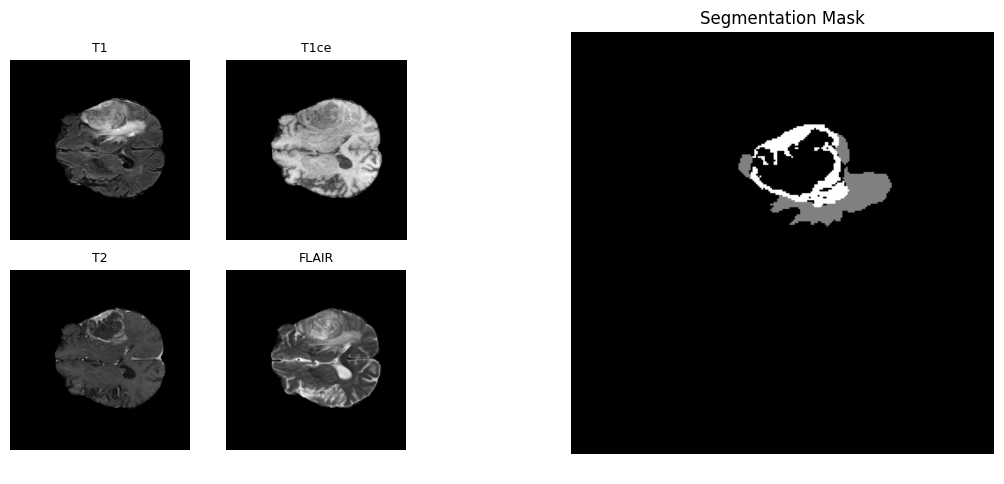

In [3]:
data_dir = '/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data'
dataset = BRATS2020Dataset(data_dir, n_sample=10000)

# Example usage
sample = dataset[130]
print(sample['image'].shape, sample['mask'].shape, sample['filename'])

# Load the image and mask
file_path = os.path.join(data_dir, sample['filename'])
with h5py.File(file_path, 'r') as f:
    image = np.array(f['image'])         # Shape: (H, W)
    mask = np.array(f['mask'])           # Shape: (H, W) or (H, W, C)

    print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")

    # If mask has multiple channels (e.g., 3-class one-hot), take argmax (GPT referred here)
    if mask.ndim == 3:
        mask_display = np.argmax(mask, axis=-1)
    else:
        mask_display = mask


# GPT referred for plotting
# Modality labels
modality_names = ['T1', 'T1ce', 'T2', 'FLAIR']

# Create figure with 2 main panels
fig = plt.figure(figsize=(12, 6))

# Subplot 1: 2x2 grid for the 4 modalities
grid_ax = plt.subplot(1, 2, 1)
grid_ax.axis('off')  # Hide the outer subplot (acts as container)

# 2x2 grid of subplots within subplot 1
for i in range(4):
    row = i // 2
    col = i % 2
    ax = fig.add_axes([0.08 + col*0.18, 0.15 + (1 - row)*0.35, 0.15, 0.3])  # [left, bottom, width, height]
    ax.imshow(image[:, :, i], cmap='gray')
    ax.set_title(modality_names[i], fontsize=9)
    ax.axis('off')

# Subplot 2: Segmentation mask
ax_mask = plt.subplot(1, 2, 2)
ax_mask.imshow(mask_display, cmap='gray')
ax_mask.set_title('Segmentation Mask')
ax_mask.axis('off')
plt.show()

In [4]:
train_ratio = 0.7
test_ratio = 0.1
val_ratio = 1- train_ratio - test_ratio
train_size = int(train_ratio * len(dataset)) 
val_size = int(test_ratio * len(dataset))  
test_size = len(dataset) - train_size - val_size  

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
batch_size= 16
train_loader= DataLoader(train_dataset, batch_size= batch_size, shuffle= True)
val_loader= DataLoader(val_dataset, batch_size= batch_size, shuffle = False)
test_loader= DataLoader(test_dataset, batch_size= batch_size, shuffle= False)

In [5]:
# Vanilla U-Netlocks with modifications from Midterm

######################################## Double Convolution
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

    
######################################## Maxpooling followed by Double Convolution
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


######################################## Upsampling followed by Double Convolution
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
        ) 
        self.conv = DoubleConv(out_channels * 2, out_channels)


    def forward(self, x1, x2):
        x1 = self.up_conv(x1)
        x = torch.cat([x1, x2], dim=1)
        x = self.conv(x)
        return x

######################################## Output layer (1x1 Convolution followed by SoftMax activation)
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv_sigmoid = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv_sigmoid(x)

In [6]:
# Model Architecture
class UNet(nn.Module):
    def __init__(self, name, n_channels, n_classes):
        super(UNet, self).__init__()
        self.name = name
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        self.inputL = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.down_extra = Down(512, 512)
        
        self.up_extra = Up(512, 512)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outputL = OutConv(64, n_classes)
        
        
    def forward(self, x):
        x1 = self.inputL(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x_extra = self.down_extra(x4)
        b = self.down4(x_extra)
        
        x = self.up1(b, x_extra)
        x = self.up_extra(x, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        x = self.outputL(x)
        
        return x

In [7]:
input_channel = 4
output_channel = 4
my_UNet = UNet('MyUNet', input_channel, output_channel)
my_UNet.cuda()

UNet(
  (inputL): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, mom

Image shape: torch.Size([16, 4, 256, 256])
Mask shape: torch.Size([16, 256, 256])
Prediction shape: torch.Size([16, 4, 256, 256])


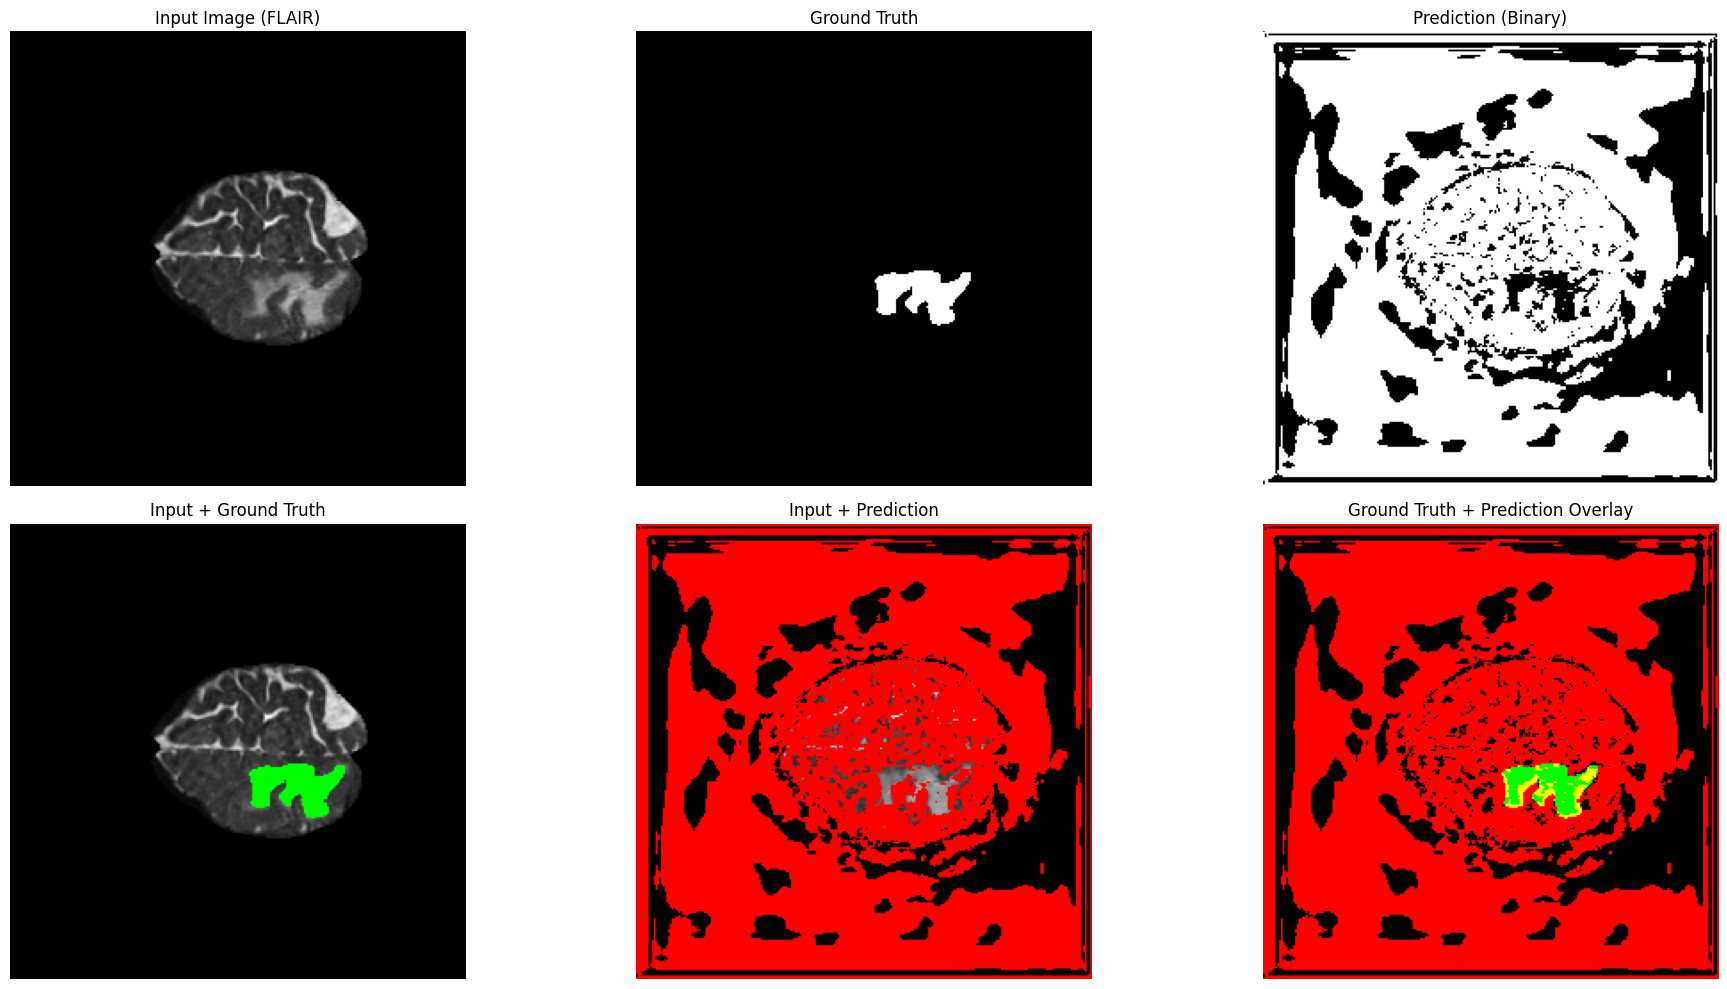

In [8]:
# Referred to midterm notebook for this piece of function
# Take the first batch from your custom test dataloader
for batch in test_loader:
    sample_batch = batch
    break  # just one sample

# Inference
with torch.no_grad():
    input_img = sample_batch['image'].cuda()  # shape: [1, 4, H, W]
    y_pred = my_UNet(input_img)

# Print shapes
print('Image shape:', sample_batch['image'].shape)
print('Mask shape:', sample_batch['mask'].shape)
print('Prediction shape:', y_pred.shape)

# Get grayscale image for visualization — e.g., FLAIR (channel 3) of sample 0
img = sample_batch['image'][0, 3].cpu().numpy()  # shape: (256, 256)
img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
img = (img * 255).astype('uint8')  # Convert to uint8 for display

# Ground truth mask for sample 0
msk = sample_batch['mask'][0].cpu().numpy()  # shape: (256, 256)
msk_bin = (msk > 0).astype('uint8') * 255  # Binary version for overlaying

# Prediction for sample 0
pred_softmax = torch.softmax(y_pred, dim=1)  # shape: [16, 4, 256, 256]
pred_class = torch.argmax(pred_softmax, dim=1)[0].cpu().numpy()  # shape: (256, 256)
pred_bin = (pred_class > 0).astype('uint8') * 255  # Binary for overlay

plt.figure(figsize=(20, 10))

plt.subplot(2,3,1)
plt.title('Input Image (FLAIR)')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2,3,2)
plt.title('Ground Truth')
plt.imshow(msk_bin, cmap='gray')
plt.axis('off')

plt.subplot(2,3,3)
plt.title('Prediction (Binary)')
plt.imshow(pred_bin, cmap='gray')
plt.axis('off')

# Overlay GT on input
img_overlay_gt = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img_overlay_gt[msk_bin == 255] = [0, 255, 0]

plt.subplot(2,3,4)
plt.title('Input + Ground Truth')
plt.imshow(img_overlay_gt)
plt.axis('off')

# Overlay Pred on input
img_overlay_pred = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img_overlay_pred[pred_bin == 255] = [255, 0, 0]

plt.subplot(2,3,5)
plt.title('Input + Prediction')
plt.imshow(img_overlay_pred)
plt.axis('off')

# Overlay both
combined = cv2.cvtColor(np.zeros_like(img), cv2.COLOR_GRAY2RGB)
combined[msk_bin == 255, 1] = 255  # green
combined[pred_bin == 255, 0] = 255  # red

plt.subplot(2,3,6)
plt.title('Ground Truth + Prediction Overlay')
plt.imshow(combined)
plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
optimizer = torch.optim.Adam(my_UNet.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [10]:
# Reference: Midterm Notebook

# Define a function that computes the Jaccard score for binary segmentation
def dice_coeff_multiclass(y_pred, y_true, num_classes=4, eps=1e-6):
    dices = []
    for cls in range(1, num_classes):  # skip background
        pred_cls = (y_pred == cls).float()
        true_cls = (y_true == cls).float()
        pred_sum = torch.sum(pred_cls)
        true_sum = torch.sum(true_cls)
        if pred_sum + true_sum == 0:
            continue  # skip class with no pixels in both pred and GT
        inter = torch.sum(pred_cls * true_cls)
        union = pred_sum + true_sum
        dice = (2 * inter + eps) / (union + eps)
        dices.append(dice.item())
    return np.mean(dices) if len(dices) > 0 else 0.0
    
# Define a function that computes the DICE score for binary segmentation
def jaccard_coeff_multiclass(y_pred, y_true, num_classes=4, eps=1e-6):
    jaccards = []
    for cls in range(1, num_classes):
        pred_cls = (y_pred == cls).float()
        true_cls = (y_true == cls).float()
        pred_sum = torch.sum(pred_cls)
        true_sum = torch.sum(true_cls)
        if pred_sum + true_sum == 0:
            continue  # skip class with no activity
        inter = torch.sum(pred_cls * true_cls)
        union = pred_sum + true_sum - inter
        jaccard = (inter + eps) / (union + eps)
        jaccards.append(jaccard.item())
    return np.mean(jaccards) if len(jaccards) > 0 else 0.0
    

# The training function
def train_net(net, epochs, train_dataloader, valid_dataloader, optimizer, loss_function):
    
    if not os.path.isdir('{0}'.format(net.name)):
        os.mkdir('{0}'.format(net.name))
    
    n_train = len(train_dataloader)
    n_valid = len(valid_dataloader)    
    
    train_loss = list()
    valid_loss = list()
    train_dice = list()
    valid_dice = list()
    train_jaccard = list()
    valid_jaccard = list()
    
    for epoch in range(epochs):
        
        ################################################################################################################################
        ########################################################### Training ###########################################################
        ################################################################################################################################
        net.train()
        train_batch_loss = list()
        train_batch_dice = list()
        train_batch_jaccard = list()
        
        for i, batch in enumerate(train_dataloader):

            # Load a batch and pass it to the GPU
            imgs = batch['image'].cuda()
            true_masks = batch['mask'].cuda()

            # Produce the estimated mask using current weights
            y_pred = net(imgs)

            # Compute the loss for this batch and append it to the epoch loss
            loss = loss_function(y_pred, true_masks)
            batch_loss = loss.item()
            train_batch_loss.append(batch_loss)

            # Make the binary mask to compute the DICE score. Since the y_pred is a Pytoch tensor, we use `torch.argmax()` instead of `np.argmax()`.
            # the axis must be 1 instead of 0 because the format is [batch, channel, height, width]
            pred_class = torch.argmax(y_pred, dim=1)
            
            # Compute the DICE score for this batch and append it to the epoch dice
            batch_dice_score = dice_coeff_multiclass(pred_class, true_masks)
            train_batch_dice.append(batch_dice_score)
                        
            # Compute the Jaccard score here and 
            batch_jaccard_score = jaccard_coeff_multiclass(pred_class, true_masks)
            train_batch_jaccard.append(batch_jaccard_score)
            

            # Reset gradient values
            optimizer.zero_grad()

            # Compute the backward losses
            loss.backward()

            # Update the weights
            optimizer.step()
            
            # Print the progress
            print(f'EPOCH {epoch + 1}/{epochs} - Training Batch {i+1}/{n_train} - Loss: {batch_loss}, DICE score: {batch_dice_score}, Jaccard score: {batch_jaccard_score}            ', end='\r')
        
        average_training_loss = np.array(train_batch_loss).mean()
        average_training_dice = np.mean(train_batch_dice) if train_batch_dice else 0.0
        average_training_jaccard = np.array(train_batch_jaccard).mean() if train_batch_jaccard else 0.0
        train_loss.append(average_training_loss)
        train_dice.append(average_training_dice)
        train_jaccard.append(average_training_jaccard)
        
        ################################################################################################################################
        ########################################################## Validation ##########################################################
        ################################################################################################################################
        
        net.eval()
        valid_batch_loss = list()
        valid_batch_dice = list()
        valid_batch_jaccard = list()
        
        # This part is almost the same as training with the difference that we will set all layers to evaluation mode (effects some layers such as BN and Dropout) and also
        # we don't need to calculate the gradient since we are only evaluating current state of the model. This will speed up the process and cause it to consume less memory.
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):

                # Load a batch and pass it to the GPU
                imgs = batch['image'].cuda()
                true_masks = batch['mask'].cuda()

                # Produce the estimated mask using current weights
                y_pred = net(imgs)

                # Compute the loss for this batch and append it to the epoch loss
                loss = loss_function(y_pred, true_masks)
                batch_loss = loss.item()
                valid_batch_loss.append(batch_loss)

                # Make the binary mask to compute the DICE score. Since the y_pred is a Pytoch tensor, we use `torch.argmax()` instead of `np.argmax()`.
                # the axis must be 1 instead of 0 because the format is [batch, channel, height, width]
                pred_class = torch.argmax(y_pred, dim=1)

                # Compute the DICE score for this batch and append it to the epoch dice
                batch_dice_score = dice_coeff_multiclass(pred_class, true_masks)
                valid_batch_dice.append(batch_dice_score)
                                
                # Compute the Jaccard score here and append the score to the list
                batch_jaccard_score = jaccard_coeff_multiclass(pred_class, true_masks)
                valid_batch_jaccard.append(batch_jaccard_score)

                # Print the progress
                print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {batch_loss}, DICE score: {batch_dice_score}, Jaccard score: {batch_jaccard_score}            ', end='\r')
                
        average_validation_loss = np.array(valid_batch_loss).mean()
        average_validation_dice = np.array(valid_batch_dice).mean() if valid_batch_dice else 0.0
        average_validation_jaccard = np.array(valid_batch_jaccard).mean() if valid_batch_jaccard else 0.0
        valid_loss.append(average_validation_loss)
        valid_dice.append(average_validation_dice)
        valid_jaccard.append(average_validation_jaccard)
        
        print(f'EPOCH {epoch + 1}/{epochs} - Training Loss: {average_training_loss}, Training DICE score: {average_training_dice}, Training Jaccard score: {average_training_jaccard}, Validation Loss: {average_validation_loss}, Validation DICE score: {average_validation_dice}, Validation Jaccard score: {average_validation_jaccard}')

        ################################################################################################################################
        ###################################################### Saveing Checkpoints #####################################################
        ################################################################################################################################
        torch.save(net.state_dict(), f'{net.name}/epoch_{epoch+1:03}.pth')
    
    return train_loss, train_dice, train_jaccard, valid_loss, valid_dice, valid_jaccard

In [11]:
EPOCHS = 30
train_loss, train_dice, train_jaccard, valid_loss, valid_dice, valid_jaccard = train_net(my_UNet, EPOCHS, train_loader, val_loader, optimizer, loss_function)

EPOCH 1/30 - Training Loss: 0.8156412226152202, Training DICE score: 0.2009631115703073, Training Jaccard score: 0.14734500441701298, Validation Loss: 0.7539549611863636, Validation DICE score: 0.22092900777400606, Validation Jaccard score: 0.1675746708297994
EPOCH 2/30 - Training Loss: 0.7509564603572567, Training DICE score: 0.36302018182092166, Training Jaccard score: 0.28361837373360105, Validation Loss: 0.7487729579683334, Validation DICE score: 0.47985723574102096, Validation Jaccard score: 0.38375522786562466
EPOCH 3/30 - Training Loss: 0.7483814210380049, Training DICE score: 0.5686021383114016, Training Jaccard score: 0.4519452250389038, Validation Loss: 0.7475156755674452, Validation DICE score: 0.6242412241669822, Validation Jaccard score: 0.5012101267458356
EPOCH 4/30 - Training Loss: 0.7474734878431172, Training DICE score: 0.6725722614877534, Training Jaccard score: 0.5396757216928969, Validation Loss: 0.7473130481583732, Validation DICE score: 0.6760899250345691, Validat

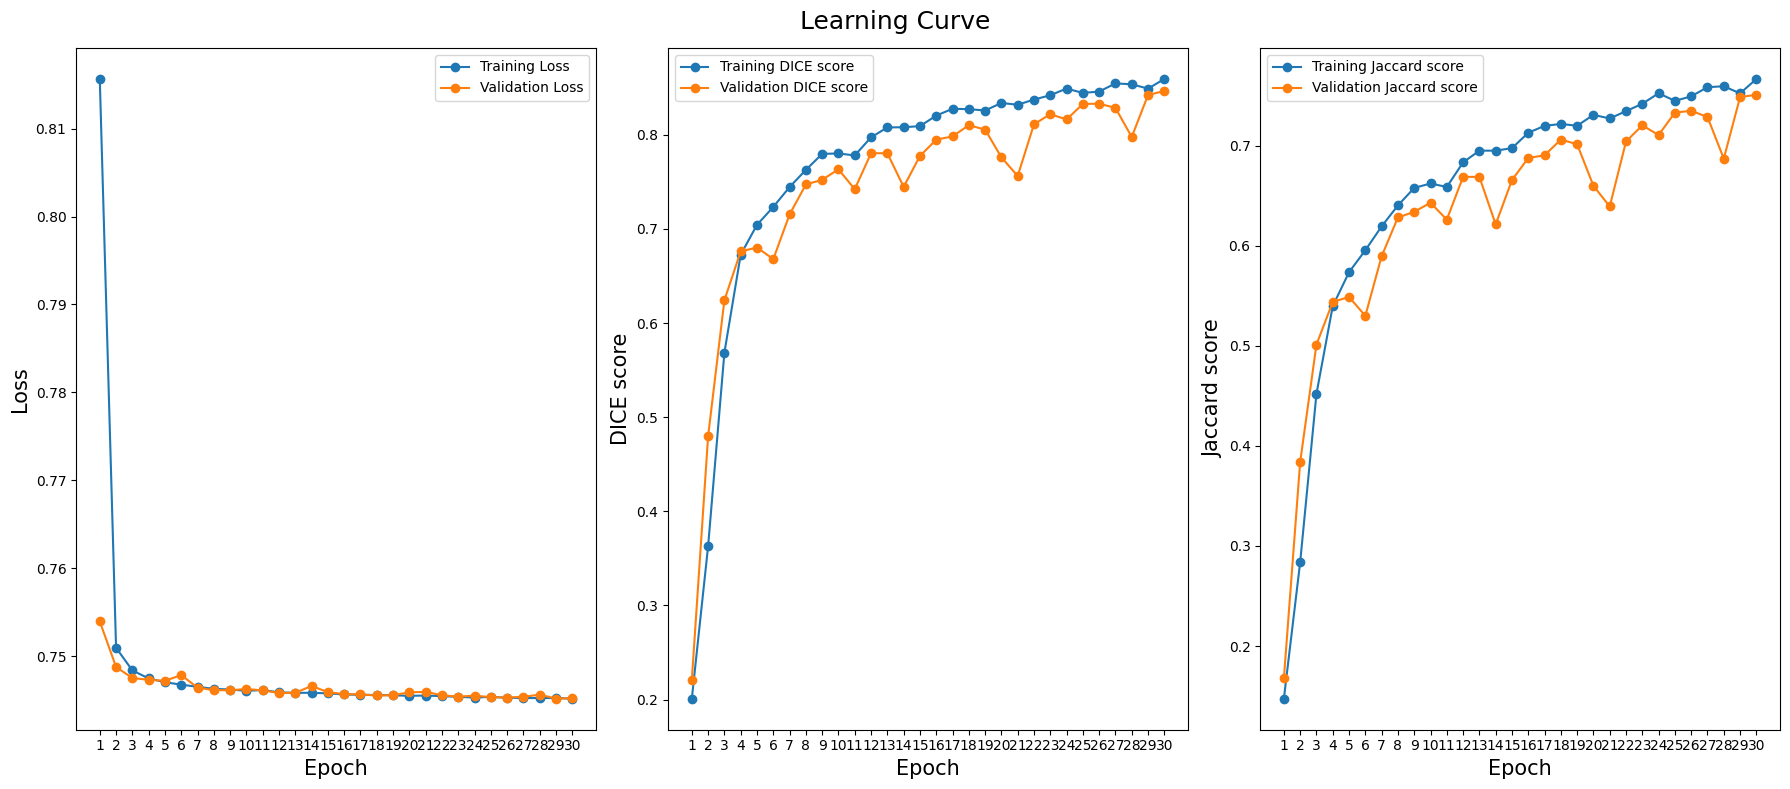

In [12]:
plt.figure(figsize=(18,8))
plt.suptitle('Learning Curve', fontsize=18)

plt.subplot(1,3,1)
plt.plot(np.arange(EPOCHS)+1, train_loss, '-o', label='Training Loss')
plt.plot(np.arange(EPOCHS)+1, valid_loss, '-o', label='Validation Loss')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()

plt.subplot(1,3,2)
plt.plot(np.arange(EPOCHS)+1, train_dice, '-o', label='Training DICE score')
plt.plot(np.arange(EPOCHS)+1, valid_dice, '-o', label='Validation DICE score')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('DICE score', fontsize=15)
plt.legend()

plt.subplot(1,3,3)
plt.plot(np.arange(EPOCHS)+1, train_jaccard, '-o', label='Training Jaccard score')
plt.plot(np.arange(EPOCHS)+1, valid_jaccard, '-o', label='Validation Jaccard score')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Jaccard score', fontsize=15)
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
best_epoch = np.argmax(valid_dice) + 1 # The plus one is because the epochs starts at 1.

print(f'Best epoch is epoch {best_epoch}')

state_dict = torch.load(f'./MyUNet/epoch_{best_epoch:03}.pth')

best_model_path = f'./MyUNet/epoch_{best_epoch:03}.pth'
torch.save(torch.load(best_model_path), './MyUNet/best_model_Vanilla_30epochs_5May.pth')

my_UNet.load_state_dict(state_dict)
my_UNet.cuda()

Best epoch is epoch 30


/tmp/ipykernel_31/4131501345.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'./MyUNet/epoch_{best_epoch:03}.pth')
/tmp/ipykernel_31/4131501345.

UNet(
  (inputL): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, mom

Sample batch "image" shape: torch.Size([16, 4, 256, 256])
Sample batch "mask" shape: torch.Size([16, 256, 256])
Sample batch File: volume_100_slice_77.h5
Predicted mask shape: torch.Size([16, 4, 256, 256])


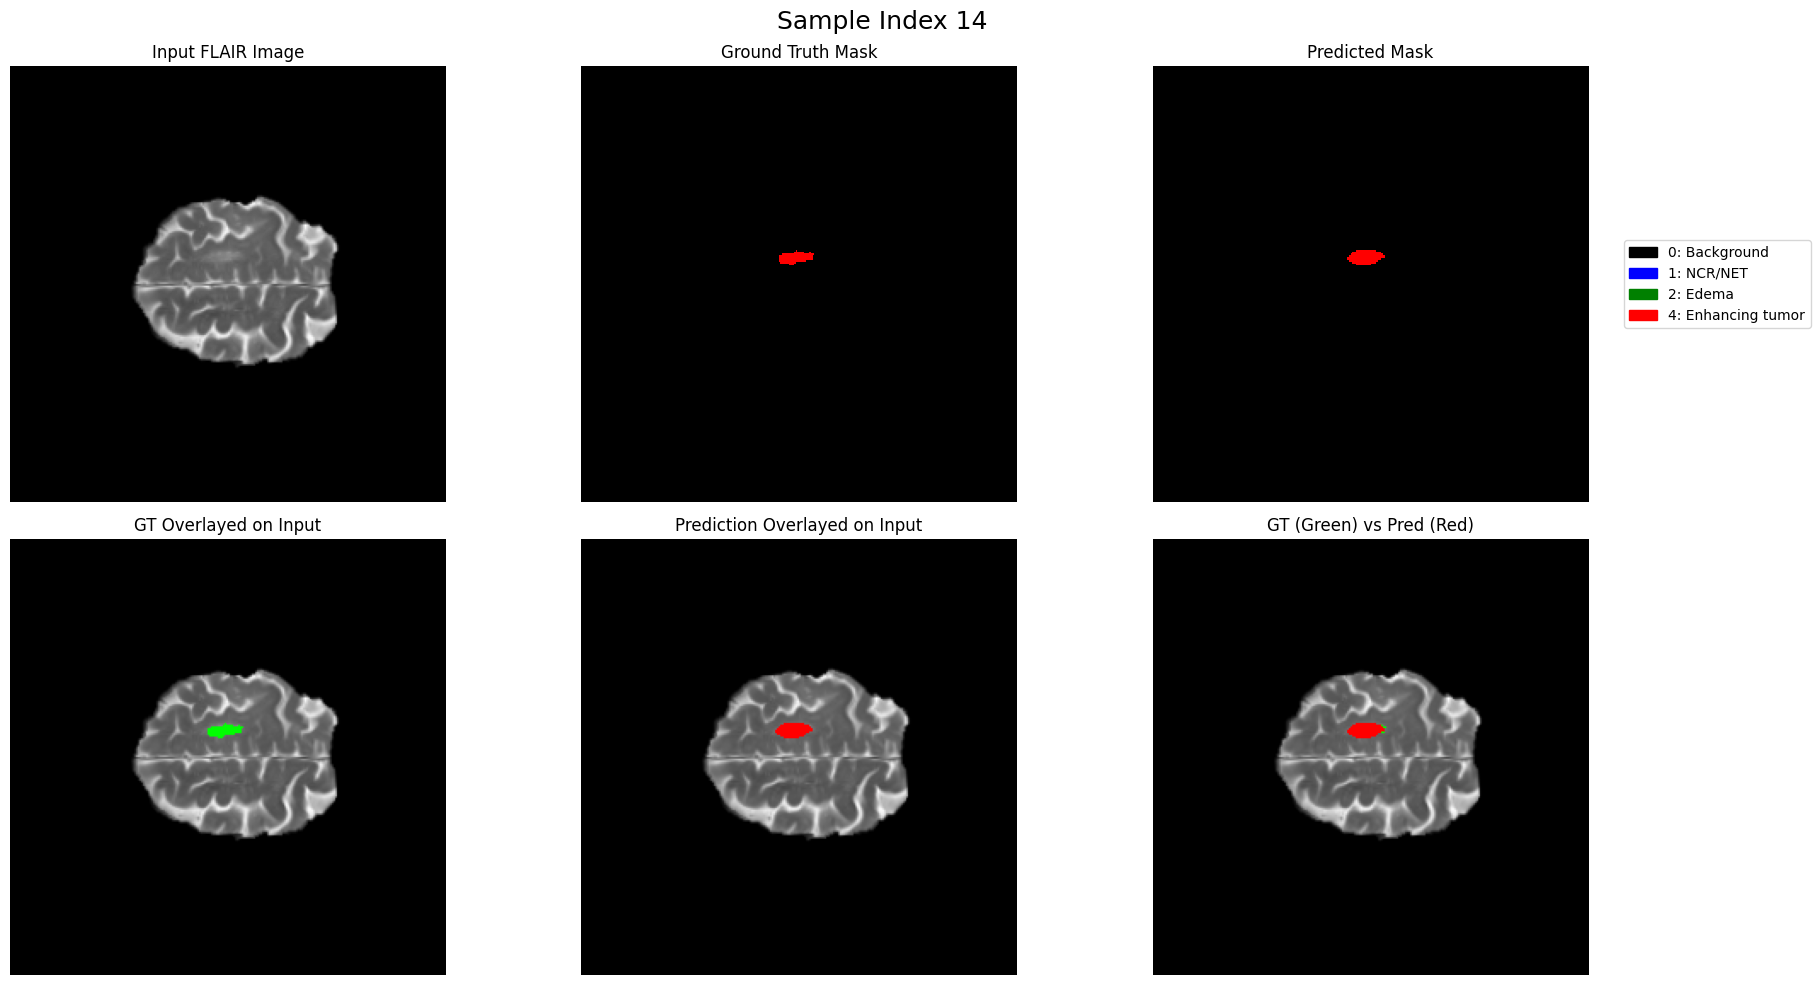

In [19]:
# Take the first batch of test set
for batch in test_loader:
    sample_batch = batch
    break

# Generate network prediction
with torch.no_grad():
    y_pred = my_UNet(sample_batch['image'].cuda())

# Print the shapes of the images, masks, predicted masks
print('Sample batch "image" shape:', sample_batch['image'].shape)
print('Sample batch "mask" shape:', sample_batch['mask'].shape)
print('Sample batch File:', sample['filename'])
print('Predicted mask shape:', y_pred.shape)

# Select the index within the batch to visualize
i = 14  # or any other index in the batch

# Extract FLAIR modality (channel 3) of the i-th image
img = sample_batch['image'][i, 3].cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
img = (img * 255).astype('uint8')  # Convert for visualization

# Ground truth mask
msk = sample_batch['mask'][i].cpu().numpy()
msk_vis = (msk > 0).astype('uint8') * 255  # Binary version

# Prediction mask
pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)[i].cpu().numpy()
pred_vis = (pred_class > 0).astype('uint8') * 255  # Binary version

# Overlay masks on input image
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
overlay_gt = img_rgb.copy()
overlay_gt[msk_vis == 255] = [0, 255, 0]  # Green for GT

overlay_pred = img_rgb.copy()
overlay_pred[pred_vis == 255] = [255, 0, 0]  # Red for prediction

overlay_both = img_rgb.copy()
overlay_both[msk_vis == 255] = [0, 255, 0]
overlay_both[pred_vis == 255] = [255, 0, 0]

# Plot the results
plt.figure(figsize=(20, 10))
plt.suptitle(f'Sample Index {i}', fontsize=18)

plt.subplot(2, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Input FLAIR Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(msk, cmap='jet')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(pred_class, cmap='jet')
plt.title('Predicted Mask')
plt.axis('off')

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

# Custom colormap to match your model's class indices
cmap_seg = ListedColormap(['black', 'blue', 'green', 'red'])  # class indices 0,1,2,3

# Replace these lines:
# plt.imshow(msk, cmap='jet')
# plt.imshow(pred_class, cmap='jet')
# With these:
plt.subplot(2, 3, 2)
plt.imshow(msk, cmap=cmap_seg, interpolation='none')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(pred_class, cmap=cmap_seg, interpolation='none')
plt.title('Predicted Mask')
plt.axis('off')

# Create legend
legend_patches = [
    Patch(color='black', label='0: Background'),
    Patch(color='blue', label='1: NCR/NET'),
    Patch(color='green', label='2: Edema'),
    Patch(color='red', label='4: Enhancing tumor'),
]

# Add a legend outside the plot grid
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=1, fontsize=10)

plt.subplot(2, 3, 4)
plt.imshow(overlay_gt)
plt.title('GT Overlayed on Input')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(overlay_pred)
plt.title('Prediction Overlayed on Input')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(overlay_both)
plt.title('GT (Green) vs Pred (Red)')
plt.axis('off')

plt.tight_layout()
plt.show()

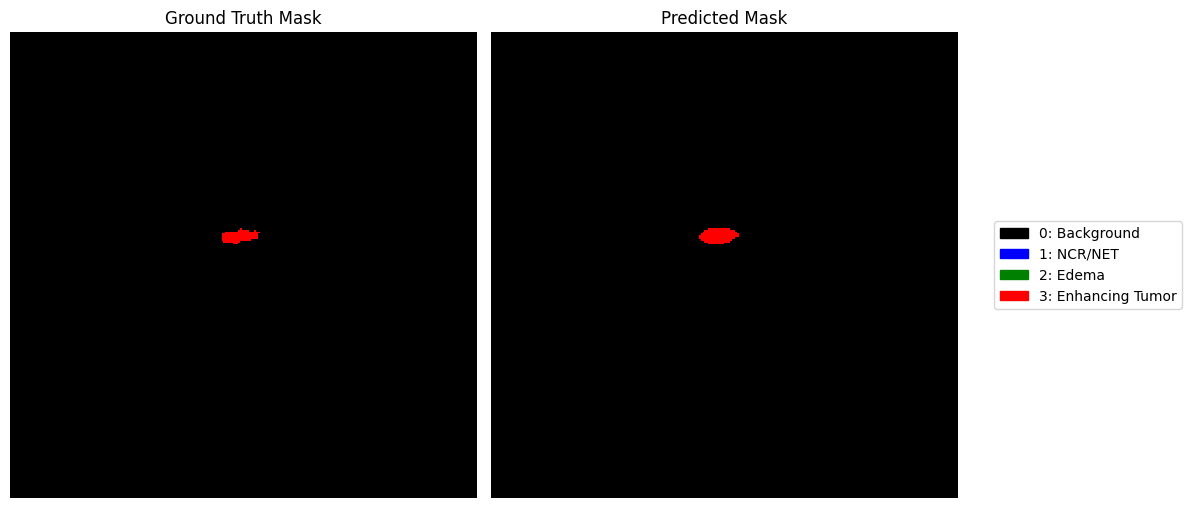

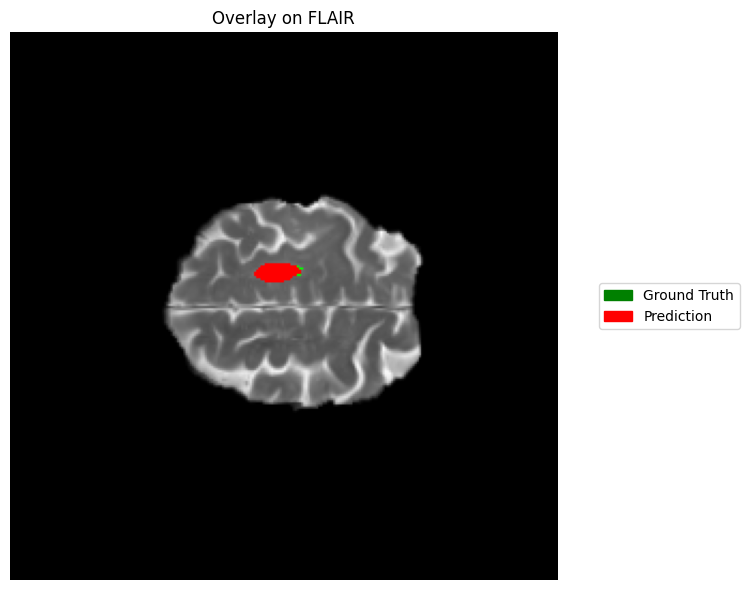

In [20]:
#Detailed Plots
# Extract file ID from full filename
filename = sample_batch['filename'][i]  # e.g., 'volume_001_slice_119.h5'
base_name = os.path.splitext(os.path.basename(filename))[0]  # removes .h5

#1
save_seg_path = f"/kaggle/working/{base_name}_segmask.png"
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

# BraTS colormap (mapped class indices: 0,1,2,3)
cmap_seg = ListedColormap(['black', 'blue', 'green', 'red'])

# Retrieve filename
filename = sample_batch['filename'][i]

plt.figure(figsize=(12, 6))
# plt.suptitle(f'[{filename}] - Ground Truth vs Predicted Mask', fontsize=14)

plt.subplot(1, 2, 1)
plt.imshow(msk, cmap=cmap_seg, interpolation='none')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_class, cmap=cmap_seg, interpolation='none')
plt.title('Predicted Mask')
plt.axis('off')

legend_patches = [
    Patch(color='black', label='0: Background'),
    Patch(color='blue', label='1: NCR/NET'),
    Patch(color='green', label='2: Edema'),
    Patch(color='red', label='3: Enhancing Tumor'),
]
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=1, fontsize=10)

plt.tight_layout()
plt.savefig(save_seg_path, dpi=300, bbox_inches='tight')
plt.show()

#2
save_overlay_path = f"/kaggle/working/{base_name}_overlay.png"
plt.figure(figsize=(10, 6))
# plt.suptitle(f'[{filename}] - Overlay: Ground Truth (Green) vs Prediction (Red)', fontsize=14)

plt.imshow(overlay_both)
plt.title('Overlay on FLAIR')
plt.axis('off')

legend_overlay = [
    Patch(color='green', label='Ground Truth'),
    Patch(color='red', label='Prediction')
]
plt.legend(handles=legend_overlay, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=1, fontsize=10)

plt.tight_layout()
plt.savefig(save_overlay_path, dpi=300, bbox_inches='tight')
plt.show()


In [21]:
#Testing Loop: Baseline reference- Midterm notebook
def test_net(net, test_dataloader, loss_function, save_dir='/kaggle/working/pred_mask', class_labels=[0, 1, 2, 4]):
    import os
    from sklearn.metrics import confusion_matrix, accuracy_score

    os.makedirs(save_dir, exist_ok=True)
    
    net.eval()
    
    test_batch_loss = []
    test_batch_dice = []
    test_batch_jaccard = []
    test_batch_accuracy = []
    test_batch_CM = []

    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            imgs = batch['image'].cuda()             # [B, 4, H, W]
            true_masks = batch['mask'].cuda()        # [B, H, W]
            filenames = batch.get('filename', [f'{i}_{j}.png' for j in range(imgs.shape[0])])  # fallback

            # Forward pass
            y_pred = net(imgs)                       # [B, C, H, W]

            # Loss
            loss = loss_function(y_pred, true_masks)
            test_batch_loss.append(loss.item())

            # Predictions
            pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)  # [B, H, W]

            # DICE & Jaccard (multiclass)
            dice = dice_coeff_multiclass(pred_class, true_masks)
            jaccard = jaccard_coeff_multiclass(pred_class, true_masks)
            test_batch_dice.append(dice)
            test_batch_jaccard.append(jaccard)

            # Accuracy & Confusion Matrix
            flat_true = true_masks.view(-1).cpu().numpy()
            flat_pred = pred_class.view(-1).cpu().numpy()
            acc = accuracy_score(flat_true, flat_pred)
            cm = confusion_matrix(flat_true, flat_pred, labels=class_labels, normalize='true')

            test_batch_accuracy.append(acc)
            test_batch_CM.append(cm)

            # Save predictions
            for k in range(pred_class.shape[0]):
                filename = os.path.splitext(os.path.basename(filenames[k]))[0]
                pred_np = pred_class[k].cpu().numpy().astype('uint8')
                save_path = os.path.join(save_dir, f'{filename}_pred.png')
                cv2.imwrite(save_path, pred_np)

            # Progress
            print(f'[TEST] Batch {i+1}/{len(test_dataloader)} - Loss: {loss.item():.4f}, Dice: {dice:.4f}, Jaccard: {jaccard:.4f}, Acc: {acc:.4f}', end='\r')

    # Aggregate metrics
    test_loss = np.mean(test_batch_loss)
    test_dice = np.mean(test_batch_dice)
    test_jaccard = np.mean(test_batch_jaccard)
    test_accuracy = np.mean(test_batch_accuracy)
    test_CM = np.mean(test_batch_CM, axis=0)

    return test_loss, test_dice, test_jaccard, test_accuracy, test_CM

Test Loss: 0.7450709266662597, Test DICE score: 0.849209405266695, Test Jaccard score: 0.7580049396986294, Test overall accuracy: 0.9983662719726563
------------------------------------------------------------------------------------------------------------------------------------


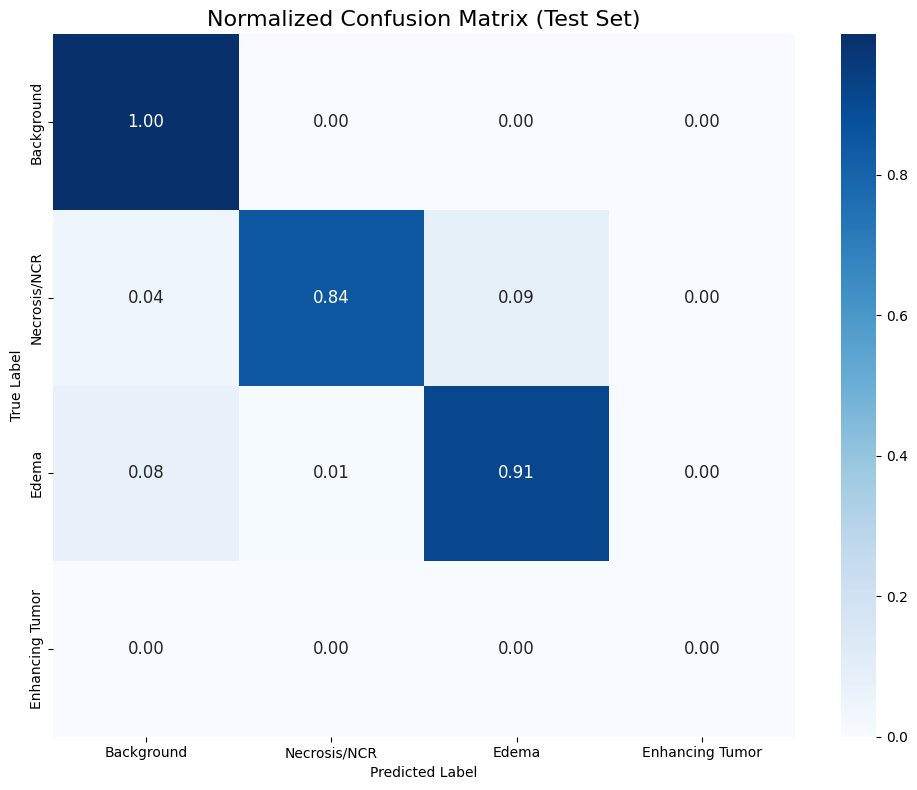

In [22]:
# Reference: Midterm Notebook
test_loss, test_dice, test_jaccard, test_accuracy, test_CM = test_net(my_UNet, test_loader, loss_function)

print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test Jaccard score: {test_jaccard}, Test overall accuracy: {test_accuracy}')
print('------------------------------------------------------------------------------------------------------------------------------------')

# BraTS label meaning
class_labels = [0, 1, 2, 4]
class_names = ['Background', 'Necrosis/NCR', 'Edema', 'Enhancing Tumor']

# Create confusion matrix DataFrame
df_cm = pd.DataFrame(test_CM, index=class_names, columns=class_names)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap='Blues', annot_kws={"size": 12})
plt.title('Normalized Confusion Matrix (Test Set)', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [ ]:
!unzip /kaggle/input/best-model/best_model.pth -d /kaggle/working/best_model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_channel = 4
output_channel = 4

# Step 1: Create the model
best_model = UNet('MyUNet', input_channel, output_channel)
best_model.to(device)

# Step 2: Load weights into it
state_dict = torch.load("/kaggle/input/best-model-vanilla/best_model_Vanilla_30epochs_5May.pth", map_location=device)
best_model.load_state_dict(state_dict)

# Step 3: Set to eval mode
best_model.eval()


/tmp/ipykernel_31/894840146.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/kaggle/input/best-model-vanilla/best_model_Vanilla_30epochs_5May.p

UNet(
  (inputL): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, mom

Sample batch "image" shape: torch.Size([16, 4, 256, 256])
Sample batch "mask" shape: torch.Size([16, 256, 256])
Predicted mask shape: torch.Size([16, 4, 256, 256])


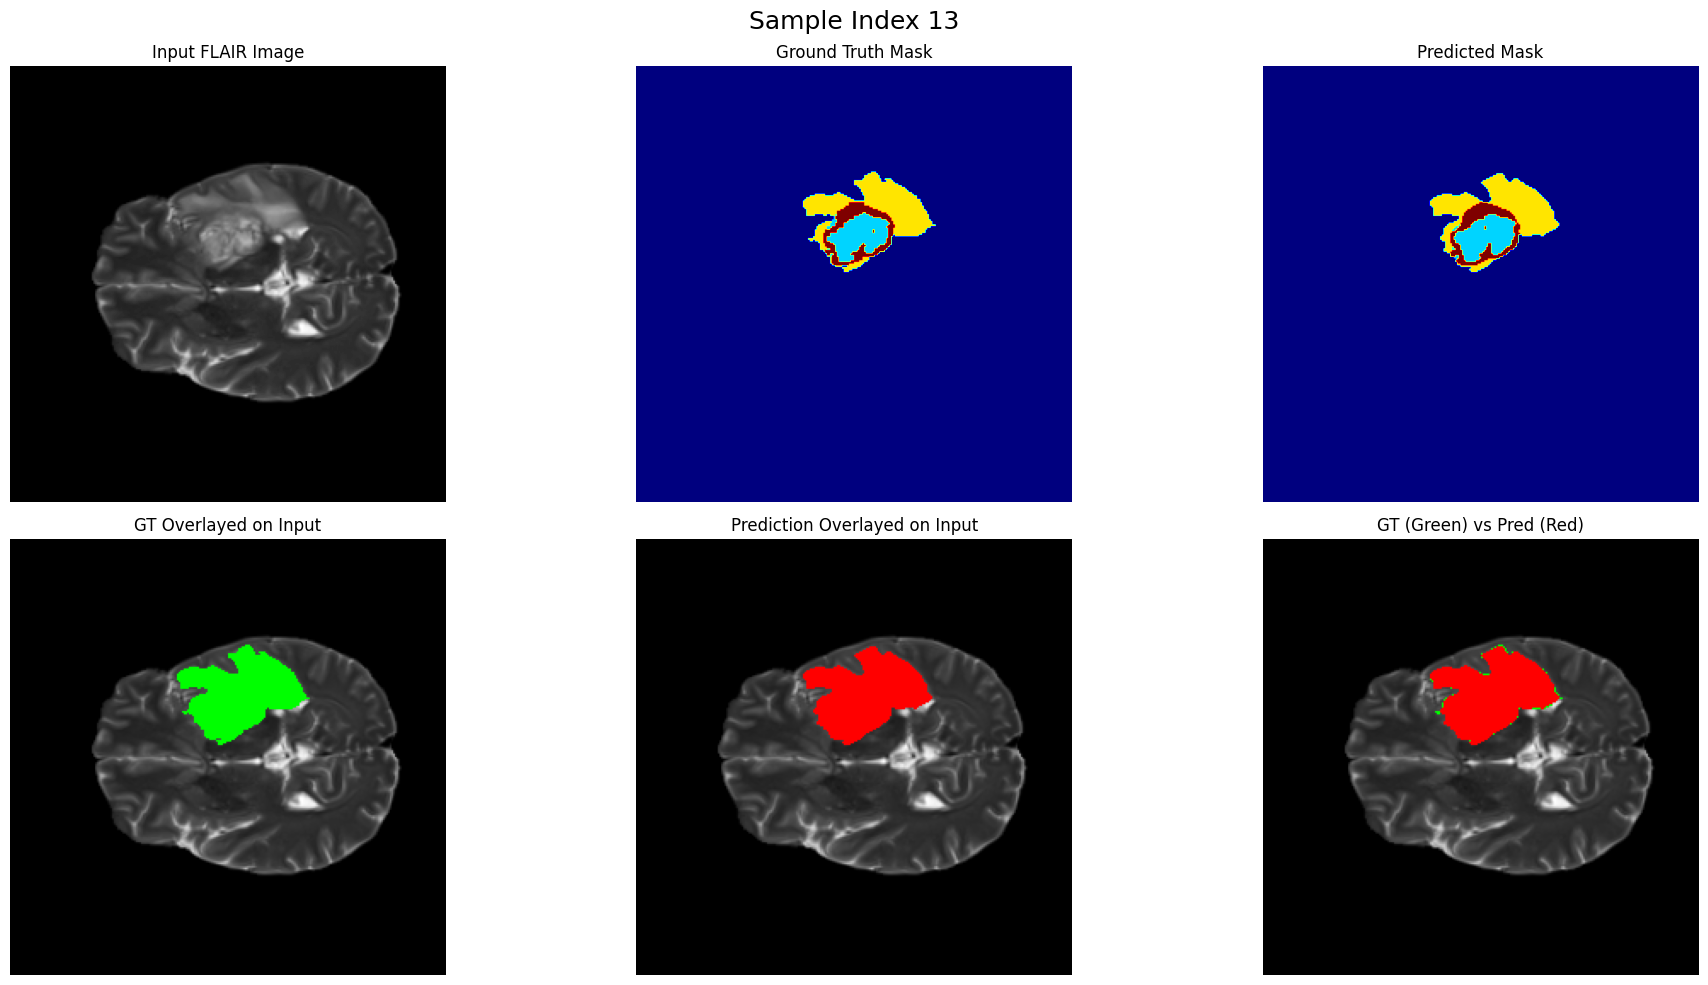

In [9]:
#Test best model after loading
# Take the second batch of test set
i= 0
for batch in test_loader:
    sample_batch = batch
    if i == 2:
        break
    i+=1

# Generate network prediction
with torch.no_grad():
    y_pred = best_model(sample_batch['image'].cuda())

# Print the shapes of the images, masks, predicted masks
print('Sample batch "image" shape:', sample_batch['image'].shape)
print('Sample batch "mask" shape:', sample_batch['mask'].shape)
print('Predicted mask shape:', y_pred.shape)

# Select the index within the batch to visualize
i = 13  # or any other index in the batch

# Extract FLAIR modality (channel 3) of the i-th image
img = sample_batch['image'][i, 3].cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
img = (img * 255).astype('uint8')  # Convert for visualization

# Ground truth mask
msk = sample_batch['mask'][i].cpu().numpy()
msk_vis = (msk > 0).astype('uint8') * 255  # Binary version

# Prediction mask
pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)[i].cpu().numpy()
pred_vis = (pred_class > 0).astype('uint8') * 255  # Binary version

# Overlay masks on input image
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
overlay_gt = img_rgb.copy()
overlay_gt[msk_vis == 255] = [0, 255, 0]  # Green for GT

overlay_pred = img_rgb.copy()
overlay_pred[pred_vis == 255] = [255, 0, 0]  # Red for prediction

overlay_both = img_rgb.copy()
overlay_both[msk_vis == 255] = [0, 255, 0]
overlay_both[pred_vis == 255] = [255, 0, 0]

# Plot the results
plt.figure(figsize=(20, 10))
plt.suptitle(f'Sample Index {i}', fontsize=18)

plt.subplot(2, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Input FLAIR Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(msk, cmap='jet')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(pred_class, cmap='jet')
plt.title('Predicted Mask')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(overlay_gt)
plt.title('GT Overlayed on Input')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(overlay_pred)
plt.title('Prediction Overlayed on Input')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(overlay_both)
plt.title('GT (Green) vs Pred (Red)')
plt.axis('off')

plt.tight_layout()
plt.show()

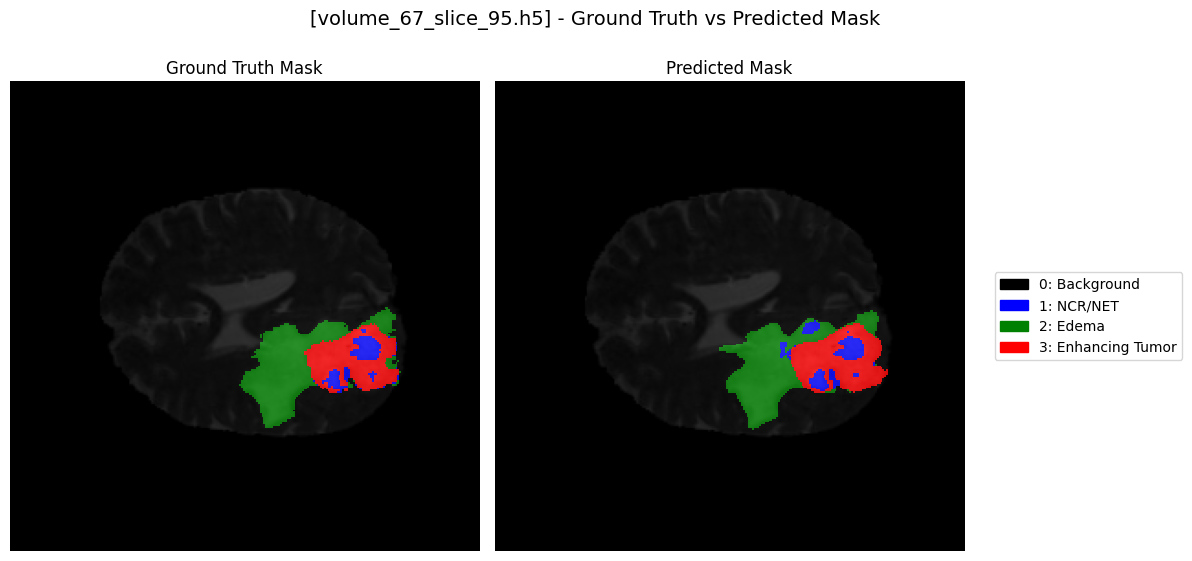

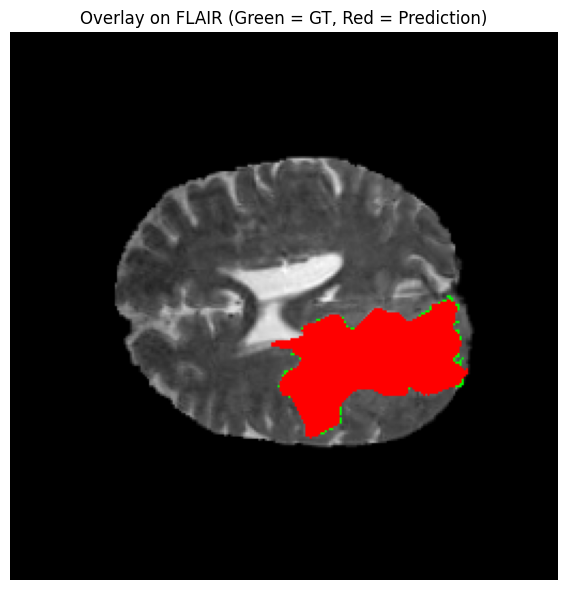

In [16]:
#Testing one particular image:
import torch
import torchvision.transforms as transforms
import cv2
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import os

# Load the file
file_path = "/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_67_slice_95.h5"
with h5py.File(file_path, 'r') as f:
    img_data = np.array(f['image'])        # (240, 240, 4)
    mask_data = np.array(f['mask'])        # (240, 240) or (240, 240, 3)

# --- Apply Dataset-style preprocessing ---

# Image transform
img_transform = transforms.Compose([
    transforms.ToTensor(),  # → (C, H, W), scaled [0, 1]
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((256, 256)),
    transforms.Normalize(mean=[0.5], std=[0.5])  # → [-1, 1]
])

# Mask transform
msk_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)
])

# Handle mask shape
if mask_data.ndim == 3:
    mask_data = np.concatenate([np.ones((*mask_data.shape[:2], 1)) * 0.1, mask_data], axis=-1)
    mask_data = np.argmax(mask_data, axis=-1)

# Apply transforms
img_tensor = img_transform(img_data)         # shape: (4, 256, 256)
mask_tensor = msk_transform(mask_data).squeeze(0).long()  # shape: (256, 256)

# Inference
input_tensor = img_tensor.unsqueeze(0).cuda()  # (1, 4, 256, 256)
best_model.eval()
with torch.no_grad():
    output = best_model(input_tensor)          # (1, num_classes, H, W)
    pred_class = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

gt_mask = mask_tensor.numpy()

# --- Visualize on FLAIR channel (channel 3) ---
flair = img_data[:, :, 3]
flair = cv2.resize(flair, (256, 256))
flair_img = ((flair - flair.min()) / (flair.max() - flair.min()) * 255).astype('uint8')
flair_rgb = cv2.cvtColor(flair_img, cv2.COLOR_GRAY2RGB)

# Binary masks
gt_vis = (gt_mask > 0).astype('uint8') * 255
pred_vis = (pred_class > 0).astype('uint8') * 255

# Overlays
overlay_gt = flair_rgb.copy()
overlay_gt[gt_vis == 255] = [0, 255, 0]

overlay_pred = flair_rgb.copy()
overlay_pred[pred_vis == 255] = [255, 0, 0]

overlay_both = flair_rgb.copy()
overlay_both[gt_vis == 255] = [0, 255, 0]
overlay_both[pred_vis == 255] = [255, 0, 0]

# --- Plot results ---
filename = os.path.basename(file_path)

# Plot 1: Segmentation masks
plt.figure(figsize=(12, 6))
plt.suptitle(f'[{filename}] - Ground Truth vs Predicted Mask', fontsize=14)

cmap_seg = ListedColormap(['black', 'blue', 'green', 'red'])  # For labels 0-3

plt.subplot(1, 2, 1)
plt.imshow(flair_img,cmap='gray')
plt.imshow(gt_mask, cmap=cmap_seg, alpha=0.8, interpolation='none')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(flair_img,cmap='gray')
plt.imshow(pred_class, cmap=cmap_seg, alpha=0.8, interpolation='none')
plt.title('Predicted Mask')
plt.axis('off')

legend_patches = [
    Patch(color='black', label='0: Background'),
    Patch(color='blue', label='1: NCR/NET'),
    Patch(color='green', label='2: Edema'),
    Patch(color='red', label='3: Enhancing Tumor'),
]
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize=10)
plt.tight_layout()
plt.savefig('/kaggle/working/Vanilla_pred_sep.png')
plt.show()

# Plot 2: Overlay
plt.figure(figsize=(6, 6))
# plt.suptitle(f'[{filename}] - Overlay: GT (Green) vs Prediction (Red)', fontsize=14)
plt.imshow(overlay_both)
plt.title("Overlay on FLAIR (Green = GT, Red = Prediction)")
plt.axis('off')

legend_overlay = [
    Patch(color='green', label='Ground Truth'),
    Patch(color='red', label='Prediction')
]
# plt.legend(handles=legend_overlay, bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize=10)
plt.tight_layout()
plt.savefig('/kaggle/working/Vanilla_pred.png')
plt.show()
